In [1]:
#| include: false

library(tidyverse)
library(kableExtra)
library(ggthemes)
library(foreach)
library(doParallel)
library(caret)
library(glmnet)
theme_set(theme_stata())
scale_color_discrete <- scale_color_stata()
scale_colour_discrete <- scale_color_stata()
rsv <- read_csv("rsv.csv") %>%
    mutate(wheeze = as.factor(wheeze),
    cyan = as.factor(cyan),)
str(rsv) %>% print

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows



Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel

Warning message:
“package ‘caret’ was built under R version 4.2.3”
Loading required package: lattice

Warning message:
“pac

tibble [1,374 × 12] (S3: tbl_df/tbl/data.frame)
 $ id     : num [1:1374] 1 2 3 4 5 6 7 8 9 10 ...
 $ age    : num [1:1374] 1 2 12 9 4 3 2 12 3 12 ...
 $ sex    : num [1:1374] 0 1 0 1 0 1 0 0 1 1 ...
 $ bwt    : num [1:1374] 3 3 2 3.1 2.8 1.6 2.8 3.4 2 3.5 ...
 $ smoke  : num [1:1374] 0 1 0 1 1 1 1 1 1 0 ...
 $ atopy  : num [1:1374] 0 0 0 0 0 0 0 0 0 0 ...
 $ fhxasth: num [1:1374] 1 0 0 0 0 0 1 0 0 1 ...
 $ resp   : num [1:1374] 60 60 38 58 44 30 47 35 51 35 ...
 $ wheeze : Factor w/ 3 levels "0","1","2": 1 2 1 3 2 2 3 2 3 2 ...
 $ cyan   : Factor w/ 3 levels "0","1","2": 3 1 1 1 1 1 2 1 1 1 ...
 $ los    : num [1:1374] 6 5 10 5 5 8 16 4 2 4 ...
 $ mmi    : num [1:1374] 1 1 1 1 1 1 1 1 0 1 ...
NULL


(a) Investigate the association between age and length of hospital stay.

In [2]:
##(a)
cor(rsv$age,rsv$los) %>% print

[1] -0.223165


(b) Establish a range of typical values for length of hospital stay for children with the following covariate profile:
• Eight months of age. • Male.
• No wheezing.

In [3]:
rsv %>%
    filter(age == 8,sex == 1,wheeze == 0) %>%
    summarise(lower = quantile(los,0.25),
                upper = quantile(los,0.75))

# What do you mean? seperate? all condition?

lower,upper
<dbl>,<dbl>
4.25,5.75


(c) Develop a prediction model for major medical intervention based on the following variables: 

• Age.
• Sex.
• Birth weight.
• Prior smoke exposure.
• Atopy.
• Family history of asthma. • Respiratory rate.
• Wheezing.
• Cyanosis.

In [10]:
## when he said develop a model, does it mean I have free choice of the model?
set.seed(123123)
train_index = createDataPartition(rsv$los,p = 0.5,list = FALSE)
train_rsv = rsv[train_index,]
test_rsv = rsv[-train_index,]

model_1 = lm(los~age+sex+bwt+smoke+atopy+fhxasth+resp+wheeze+cyan,
                             data = train_rsv)


cv.glmnet(
                x = 
    model.matrix(los~age*sex*bwt*smoke*atopy*fhxasth*resp*wheeze*cyan,
                             data = train_rsv)[,-1],
                y = train_rsv$los,
                family = "gaussian",
                type.measure = "mse",
                nfolds = 10,
)
model_2 = glmnet(                
    x = 
    model.matrix(los~age*sex*bwt*smoke*atopy*fhxasth*resp*wheeze*cyan,
                             data = train_rsv)[,-1],
                y = train_rsv$los,
                alpha = 1,
                lambda = 0.1805)


Call:  cv.glmnet(x = model.matrix(los ~ age * sex * bwt * smoke * atopy *      fhxasth * resp * wheeze * cyan, data = train_rsv)[, -1],      y = train_rsv$los, type.measure = "mse", nfolds = 10, family = "gaussian") 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.1805    31   10.30 1.158      31
1se 0.7288     1   10.82 1.216       0

In [11]:
## Predicting error
mean((predict(model_1,newdata = test_rsv) - test_rsv$los)^2)
mean(((predict(model_2,newx = 
model.matrix(los~age*sex*bwt*smoke*atopy*fhxasth*resp*wheeze*cyan,
                             data = test_rsv)[,-1])
) - test_rsv$los)^2)

[1] 11.25371

[1] 11.51547

8. 20 pts You are working with an investigative team that focuses on the use of magnetic resonance imaging (MRI) to understand variation in properties of the spinal cord. One goal in particular is to estimate specific quantiles of spinal cord volume (mm3) in the population. As is often the case, there are many approaches that could be used to accomplish this goal. Consider the following two estimation approaches for estimating the pth quantile of a distribution based on a total of n independently sampled subjects:

• An estimate based on the presumption that spinal cord volume follows a normal distribution with mean μ and variance σ2: Q̂(p) = μ̂+Φ1(p)×̂σ, where μ̂ = Xn denotes the sample mean, ̂σ denotes the sample standard deviation, and Φ1(p) denotes the pth quantile of the standard normal distribution.

• An estimate that does not make specific assumptions about the underlying distribution of spinal cord volume, based on the inverse of the empirical cumulative distribution function. This can be obtained in R through the command quantile(..., type = 1). Specifying the ‘type’ argument is important, as the default approach is different from the one described here.

In this problem, your task is to compare these two estimation approaches using Monte Carlo (simulation) based techniques. Your code for all problems must be turned in as clearly labeled supplementary .R file.

(b) For each of the two quantiles considered, present plots to compare the percentage bias and the variance of each estimator as functions of sample size (the figure will look nicer if you present the x-axis on a log-scale—e.g., with the option log="x"). Briefly summarize your findings.

In [6]:
#| include: false

## (a) simulation
# • Generate spinal cord volume under a normal distribution: X ∼ N (μ = 80, σ2 = 100).
# • Apply each of the two estimation techniques to estimate both the 50th and 97.5th percentiles of the
# spinal cord volume.
# • Vary the sample size across the following range: n = 20, 40, 80, 160, 320, 640, 1280.
# • Generate 10,000 replicates under each of the seven sample sizes.
# • Be fully reproducible and include comments that make clear the goal of key steps in your code

set.seed(123123)

fun_1 = function(x,q){
    return(mean(x) + qnorm(q)*sd(x))
}

fun_2 = function(x,q){
    return(quantile(x,q,type = 1,names = F))
}

cl = makePSOCKcluster(4)
registerDoParallel(cl)

result = 
foreach(i = 1:1e+4,
        .combine = rbind,
        .packages = c('tidyverse')
        ) %dopar%{
    .result = 
    lapply(c(20,40,80,160,320,640,1280),function(n){
        x = rnorm(n,80,sqrt(100))
        bias_1 = sapply(list(fun_1,fun_2),
                        function(f) f(x,0.5) - 80)/80
        
        bias_2 = sapply(list(fun_1,fun_2),
                        function(f) f(x,0.975) - qnorm(0.975,80,sqrt(100)))/qnorm(0.975,80,sqrt(100))
        .result = rbind(bias_1,bias_2)
        colnames(.result) = c("fn1","fn2")
        .result = .result %>%
            as.data.frame() %>%
            mutate(n = n,
                    quantile = c(0.5,0.975))
        return(.result)
    })
    do.call(rbind,.result)
}

stopCluster(cl)



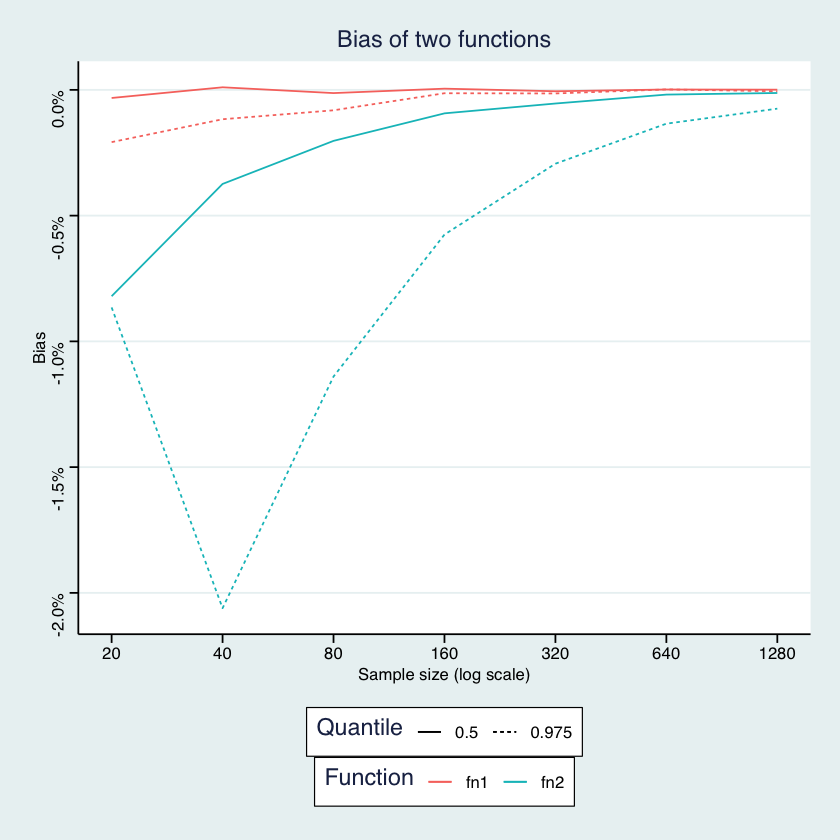

In [7]:
result %>%
    group_by(quantile,n) %>%
    summarise_all(mean) %>%
    mutate(quantile = as.factor(quantile)) %>% 
    ggplot()+
    geom_line(aes(x = n,y = fn1,linetype = quantile,group = quantile,color= "fn1"))+
    geom_line(aes(x = n,y = fn2,linetype = quantile,group = quantile,color = "fn2")) +
    scale_x_continuous(trans = "log",breaks = c(20,40,80,160,320,640,1280))+
    scale_y_continuous(labels = scales::percent)+
    labs(x = "Sample size (log scale)",
         y = "Bias",
         color = "Function",
         linetype = "Quantile",
         title = "Bias of two functions")


(d) Repeat parts (a)-(c), instead re-defining spinal cord volume to follow a shifted Gamma distribution: X=60+Z,whereZ∼Gamma(k=4,θ=5). Note: E[X]=80 and Var[X]=100,just as inpart(a).

In [8]:
#| include: false

set.seed(123123)

cl = makeCluster(4)
registerDoParallel(cl)

result = 
foreach(i = 1:1e+4,
        .combine = rbind,
        .packages = c('tidyverse')
        ) %dopar%{
    .result = 
    lapply(c(20,40,80,160,320,640,1280),function(n){
        x = rgamma(n,shape = 4, scale = 5) + 60
        bias_1 = sapply(list(fun_1,fun_2),
                        function(f) f(x,0.5) - (qgamma(0.5,shape = 4,scale =5)+60))/(qgamma(0.5,shape = 4,scale =5)+60)
        
        bias_2 = sapply(list(fun_1,fun_2),
                        function(f) f(x,0.975) - (qgamma(0.975,shape = 4,scale =5)+60))/(qgamma(0.975,shape = 4,scale = 5)+60)
        .result = rbind(bias_1,bias_2)
        colnames(.result) = c("fn1","fn2")
        .result = .result %>%
            as.data.frame() %>%
            mutate(n = n,
                    quantile = c(0.5,0.975))
        return(.result)
    })
    do.call(rbind,.result)
}

stopCluster(cl)



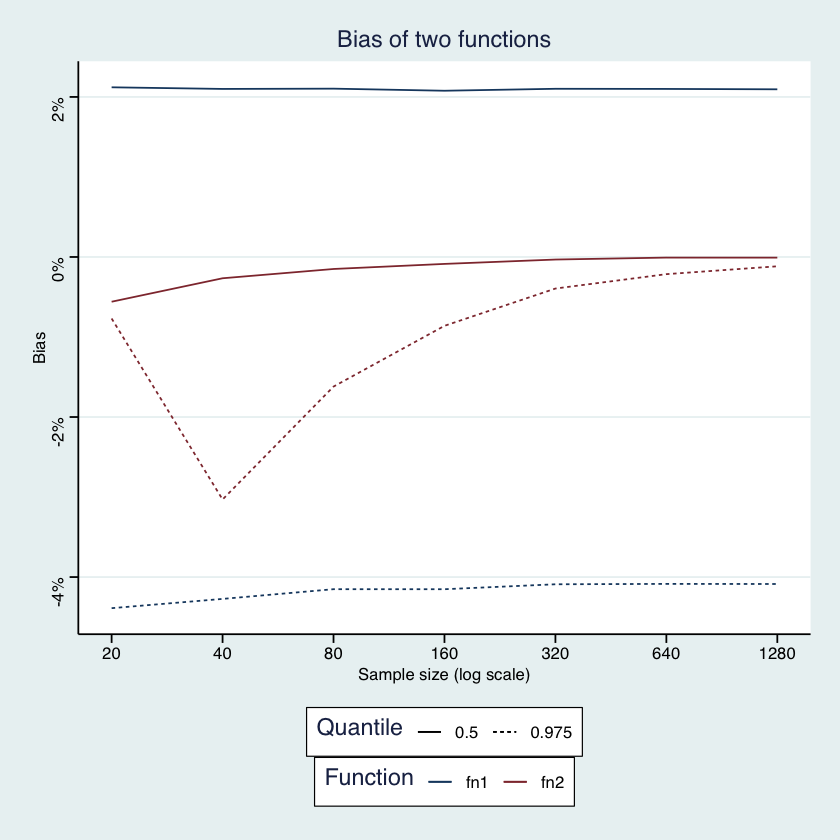

In [9]:
result %>%
    group_by(quantile,n) %>%
    summarise_all(mean) %>%
    mutate(quantile = as.factor(quantile)) %>% 
    ggplot()+
    geom_line(aes(x = n,y = fn1,linetype = quantile,group = quantile,color= "fn1"))+
    geom_line(aes(x = n,y = fn2,linetype = quantile,group = quantile,color = "fn2")) +
    scale_color_stata()+
    scale_x_continuous(trans = "log",breaks = c(20,40,80,160,320,640,1280))+
    scale_y_continuous(labels = scales::percent)+
    labs(x = "Sample size (log scale)",
         y = "Bias",
         color = "Function",
         linetype = "Quantile",
         title = "Bias of two functions")
